# CSE4214 – Pattern Recognition Lab
## Experiment No 3: Implementing Minimum Error Rate Classifier
**Student ID:** 20220104098

### Given Parameters

| | Class 1 (ω₁) | Class 2 (ω₂) |
|---|---|---|
| **Mean (μ)** | [0, 0] | [2, 2] |
| **Covariance (Σ)** | [[.25, .3], [.3, 1]] | [[.5, 0], [0, .5]] |
| **Prior P(ω)** | 0.5 | 0.5 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import io

---
## Setup: Class Parameters & Test Data

In [2]:
# ── Class Parameters ─────────────────────────────────────────────────────────
mu1    = np.array([0.0, 0.0])
Sigma1 = np.array([[0.25, 0.3],
                   [0.30, 1.0]])
P_w1   = 0.5

mu2    = np.array([2.0, 2.0])
Sigma2 = np.array([[0.5, 0.0],
                   [0.0, 0.5]])
P_w2   = 0.5

# ── Test Data (embedded inline) ───────────────────────────────────────────────
raw = """1,1
1,-1
4,5
-2,2.5
0,2
2,-3"""

test_data = np.loadtxt(io.StringIO(raw), delimiter=',')
print("Test points:")
for i, pt in enumerate(test_data):
    print(f"  x{i+1} = {pt}")

Test points:
  x1 = [1. 1.]
  x2 = [ 1. -1.]
  x3 = [4. 5.]
  x4 = [-2.   2.5]
  x5 = [0. 2.]
  x6 = [ 2. -3.]


---
## Core: Multivariate Normal Distribution (implemented from scratch)

$$N_k(\mathbf{x}_i \mid \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) = \frac{1}{\sqrt{(2\pi)^D |\boldsymbol{\Sigma}_k|}} \exp\!\left(-\frac{1}{2}(\mathbf{x}_i - \boldsymbol{\mu}_k)^T \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_k)\right)$$

In [3]:
def multivariate_normal_pdf(x, mu, Sigma):
    """
    Multivariate Gaussian PDF — implemented from scratch (no scipy/stats).
    x     : 1-D array of shape (D,)
    mu    : mean vector of shape (D,)
    Sigma : covariance matrix of shape (D, D)
    Returns: scalar probability density value
    """
    D = len(mu)
    diff = x - mu

    # Determinant and inverse computed manually via numpy linalg
    det_Sigma  = np.linalg.det(Sigma)
    inv_Sigma  = np.linalg.inv(Sigma)

    normalizer   = 1.0 / np.sqrt((2 * np.pi) ** D * det_Sigma)
    mahal_sq     = diff @ inv_Sigma @ diff        # (x-μ)ᵀ Σ⁻¹ (x-μ)
    density      = normalizer * np.exp(-0.5 * mahal_sq)
    return density


# Quick sanity check
test_pt = np.array([0.0, 0.0])
print(f"N(μ1 | μ1, Σ1) = {multivariate_normal_pdf(test_pt, mu1, Sigma1):.6f}  (should be the peak value)")

N(μ1 | μ1, Σ1) = 0.397887  (should be the peak value)


---
## Task 1 & 2: Classify Test Points & Plot with Colored Markers

**Decision Rule (Minimum Error Rate = MAP):**  
Assign **x** to class **ω₁** if $P(\omega_1) \cdot N_1(\mathbf{x}) > P(\omega_2) \cdot N_2(\mathbf{x})$, else assign to **ω₂**.

In [4]:
def classify(x, mu1, Sigma1, P_w1, mu2, Sigma2, P_w2):
    """Return class label (1 or 2) using MAP / min-error-rate decision rule."""
    posterior1 = P_w1 * multivariate_normal_pdf(x, mu1, Sigma1)
    posterior2 = P_w2 * multivariate_normal_pdf(x, mu2, Sigma2)
    return 1 if posterior1 >= posterior2 else 2


# ── Classify all test points ──────────────────────────────────────────────────
labels = []
print(f"{'Point':<15} {'x1':>6} {'x2':>6}  {'P(ω1)·N1':>14} {'P(ω2)·N2':>14}  Class")
print("-" * 70)
for i, x in enumerate(test_data):
    p1 = P_w1 * multivariate_normal_pdf(x, mu1, Sigma1)
    p2 = P_w2 * multivariate_normal_pdf(x, mu2, Sigma2)
    label = 1 if p1 >= p2 else 2
    labels.append(label)
    print(f"x{i+1} = ({x[0]:4},{x[1]:4})   {p1:14.6e}  {p2:14.6e}   ω{label}")

labels = np.array(labels)

Point               x1     x2        P(ω1)·N1       P(ω2)·N2  Class
----------------------------------------------------------------------
x1 = ( 1.0, 1.0)     2.609573e-02    2.153928e-02   ω1
x2 = ( 1.0,-1.0)     6.137128e-04    7.225623e-06   ω1
x3 = ( 4.0, 5.0)     2.441940e-15    3.597426e-07   ω2
x4 = (-2.0, 2.5)     4.763869e-13    1.394873e-08   ω2
x5 = ( 0.0, 2.0)     8.740975e-03    2.915024e-03   ω1
x6 = ( 2.0,-3.0)     8.523209e-15    2.210335e-12   ω2


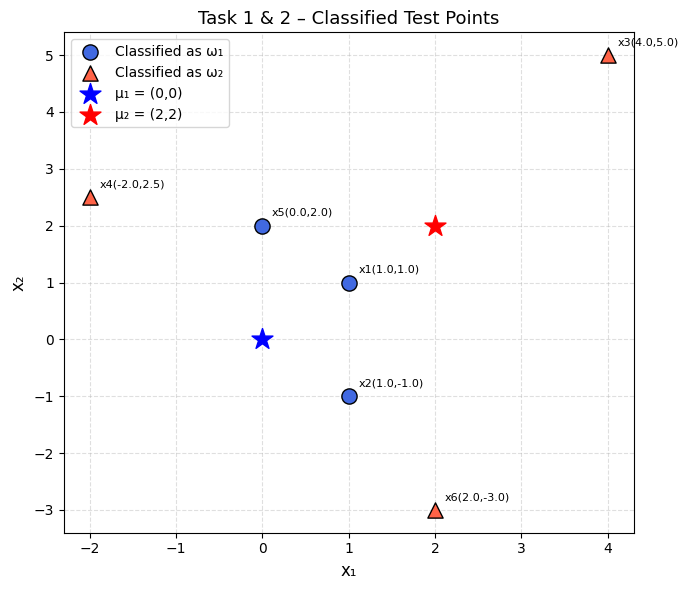

In [5]:
# ── Plot classified points ────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 6))

c1_pts = test_data[labels == 1]
c2_pts = test_data[labels == 2]

ax.scatter(c1_pts[:, 0], c1_pts[:, 1], c='royalblue', marker='o',
           s=120, edgecolors='black', zorder=5, label='Classified as ω₁')
ax.scatter(c2_pts[:, 0], c2_pts[:, 1], c='tomato',    marker='^',
           s=120, edgecolors='black', zorder=5, label='Classified as ω₂')

# Annotate points
for i, x in enumerate(test_data):
    ax.annotate(f'x{i+1}({x[0]},{x[1]})', xy=x,
                xytext=(7, 7), textcoords='offset points', fontsize=8)

# Mark class means
ax.scatter(*mu1, c='blue',  marker='*', s=250, zorder=6, label='μ₁ = (0,0)')
ax.scatter(*mu2, c='red',   marker='*', s=250, zorder=6, label='μ₂ = (2,2)')

ax.set_xlabel('x₁', fontsize=12)
ax.set_ylabel('x₂', fontsize=12)
ax.set_title('Task 1 & 2 – Classified Test Points', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('task12_classified.png', dpi=150)
plt.show()

---
## Task 3: 3-D PDF Surfaces with Contours

In [6]:
# ── Build grid ────────────────────────────────────────────────────────────────
x1_range = np.linspace(-4, 6, 200)
x2_range = np.linspace(-5, 7, 200)
X1, X2   = np.meshgrid(x1_range, x2_range)

Z1 = np.zeros_like(X1)
Z2 = np.zeros_like(X1)

for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        pt      = np.array([X1[i, j], X2[i, j]])
        Z1[i,j] = multivariate_normal_pdf(pt, mu1, Sigma1)
        Z2[i,j] = multivariate_normal_pdf(pt, mu2, Sigma2)

print(f"PDF grid computed. Z1 max={Z1.max():.4f}, Z2 max={Z2.max():.4f}")

PDF grid computed. Z1 max=0.3975, Z2 max=0.3182


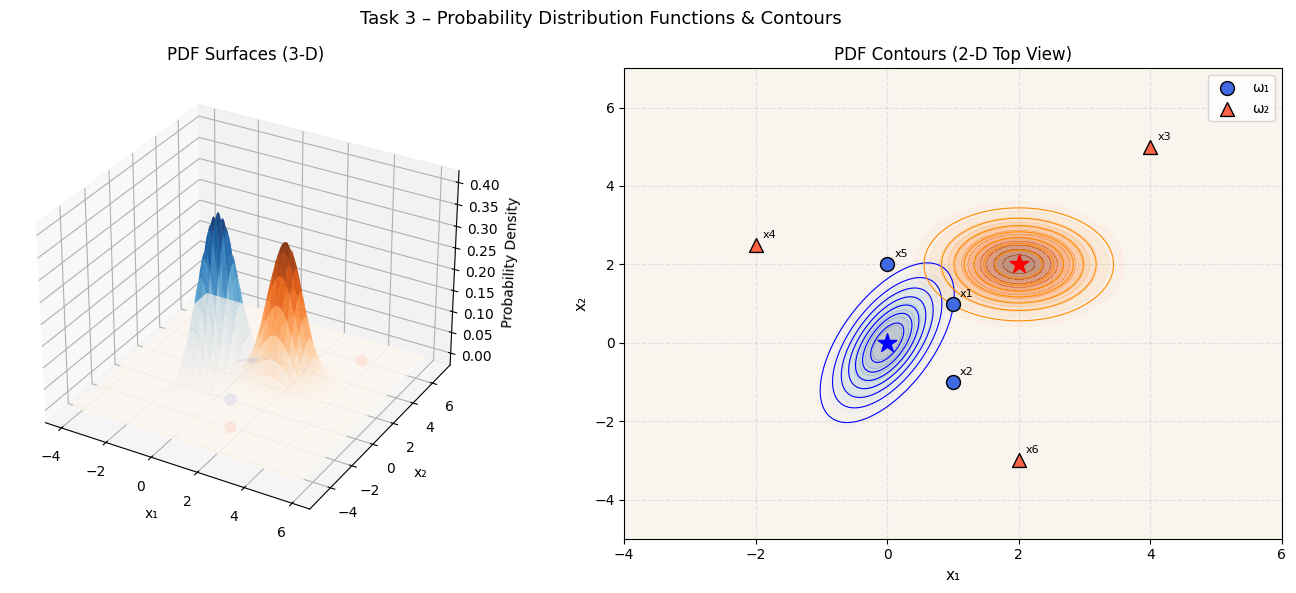

In [7]:
# ── 3-D Surface + Contour plot ────────────────────────────────────────────────
fig = plt.figure(figsize=(14, 6))

# ---- 3-D surface ----
ax3d = fig.add_subplot(121, projection='3d')
ax3d.plot_surface(X1, X2, Z1, cmap='Blues',   alpha=0.7, label='N₁')
ax3d.plot_surface(X1, X2, Z2, cmap='Oranges', alpha=0.7, label='N₂')

# Scatter classified points on the surface
for i, x in enumerate(test_data):
    z_val = max(multivariate_normal_pdf(x, mu1, Sigma1),
                multivariate_normal_pdf(x, mu2, Sigma2))
    color = 'royalblue' if labels[i] == 1 else 'tomato'
    ax3d.scatter(x[0], x[1], z_val + 0.005, c=color, s=60, zorder=10)

ax3d.set_xlabel('x₁')
ax3d.set_ylabel('x₂')
ax3d.set_zlabel('Probability Density')
ax3d.set_title('PDF Surfaces (3-D)', fontsize=12)
ax3d.view_init(elev=30, azim=-60)

# ---- 2-D Contour ----
ax2d = fig.add_subplot(122)
cp1 = ax2d.contourf(X1, X2, Z1, levels=12, cmap='Blues',   alpha=0.5)
cp2 = ax2d.contourf(X1, X2, Z2, levels=12, cmap='Oranges', alpha=0.5)
ax2d.contour(X1, X2, Z1, levels=8, colors='blue',   linewidths=0.8)
ax2d.contour(X1, X2, Z2, levels=8, colors='darkorange', linewidths=0.8)

# Plot classified test points
ax2d.scatter(c1_pts[:, 0], c1_pts[:, 1], c='royalblue', marker='o',
             s=100, edgecolors='black', zorder=5, label='ω₁')
ax2d.scatter(c2_pts[:, 0], c2_pts[:, 1], c='tomato',    marker='^',
             s=100, edgecolors='black', zorder=5, label='ω₂')
ax2d.scatter(*mu1, c='blue', marker='*', s=200, zorder=6)
ax2d.scatter(*mu2, c='red',  marker='*', s=200, zorder=6)

for i, x in enumerate(test_data):
    ax2d.annotate(f'x{i+1}', xy=x, xytext=(5, 5),
                  textcoords='offset points', fontsize=8)

ax2d.set_xlabel('x₁', fontsize=11)
ax2d.set_ylabel('x₂', fontsize=11)
ax2d.set_title('PDF Contours (2-D Top View)', fontsize=12)
ax2d.legend(fontsize=10)
ax2d.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Task 3 – Probability Distribution Functions & Contours', fontsize=13)
plt.tight_layout()
plt.savefig('task3_pdf_contour.png', dpi=150)
plt.show()

---
## Task 4: Decision Boundary

The decision boundary is where the two posteriors are equal:
$$P(\omega_1)\, N_1(\mathbf{x}) = P(\omega_2)\, N_2(\mathbf{x})$$
Since $P(\omega_1) = P(\omega_2) = 0.5$, this simplifies to $N_1(\mathbf{x}) = N_2(\mathbf{x})$,  
i.e., the contour where $N_1(\mathbf{x}) - N_2(\mathbf{x}) = 0$.

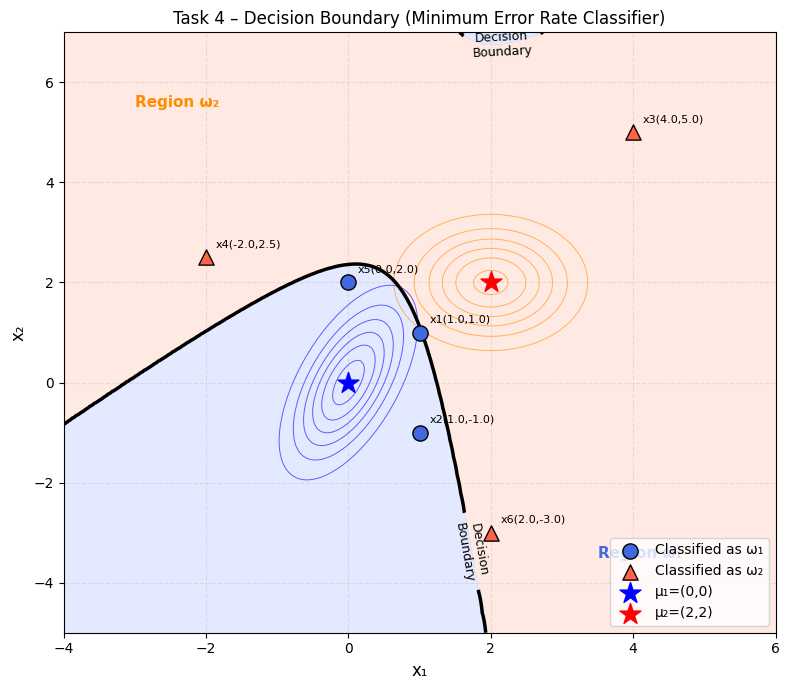

In [8]:
# ── Decision boundary = zero contour of (P1*N1 - P2*N2) ──────────────────────
DIFF = P_w1 * Z1 - P_w2 * Z2

fig, ax = plt.subplots(figsize=(8, 7))

# Filled decision regions
ax.contourf(X1, X2, DIFF, levels=[-np.inf, 0, np.inf],
            colors=['#FFD6C8', '#C8D6FF'], alpha=0.5)

# PDF contours (background)
ax.contour(X1, X2, Z1, levels=6, colors='blue',       linewidths=0.7, alpha=0.6)
ax.contour(X1, X2, Z2, levels=6, colors='darkorange',  linewidths=0.7, alpha=0.6)

# Decision boundary
db = ax.contour(X1, X2, DIFF, levels=[0], colors='black', linewidths=2.5)
ax.clabel(db, fmt='Decision\nBoundary', fontsize=9)

# Classified test points
ax.scatter(c1_pts[:, 0], c1_pts[:, 1], c='royalblue', marker='o',
           s=120, edgecolors='black', zorder=6, label='Classified as ω₁')
ax.scatter(c2_pts[:, 0], c2_pts[:, 1], c='tomato',    marker='^',
           s=120, edgecolors='black', zorder=6, label='Classified as ω₂')

# Means
ax.scatter(*mu1, c='blue', marker='*', s=250, zorder=7, label='μ₁=(0,0)')
ax.scatter(*mu2, c='red',  marker='*', s=250, zorder=7, label='μ₂=(2,2)')

# Annotate region labels
ax.text(-3, 5.5, 'Region ω₂', fontsize=11, color='darkorange', fontweight='bold')
ax.text(3.5, -3.5, 'Region ω₁', fontsize=11, color='royalblue', fontweight='bold')

for i, x in enumerate(test_data):
    ax.annotate(f'x{i+1}({x[0]},{x[1]})', xy=x,
                xytext=(7, 7), textcoords='offset points', fontsize=8)

ax.set_xlabel('x₁', fontsize=12)
ax.set_ylabel('x₂', fontsize=12)
ax.set_title('Task 4 – Decision Boundary (Minimum Error Rate Classifier)', fontsize=12)
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_xlim(-4, 6)
ax.set_ylim(-5, 7)

plt.tight_layout()
plt.savefig('task4_decision_boundary.png', dpi=150)
plt.show()

---
## Summary of Classification Results

| Point | Coordinates | Assigned Class |
|-------|-------------|----------------|
| x₁ | (1, 1)   | ? |
| x₂ | (1, −1)  | ? |
| x₃ | (4, 5)   | ? |
| x₄ | (−2, 2.5)| ? |
| x₅ | (0, 2)   | ? |
| x₆ | (2, −3)  | ? |

*(Run the cells above — the table is printed dynamically with actual class assignments.)*

In [9]:
# ── Final summary printout ────────────────────────────────────────────────────
print("\n===== CLASSIFICATION RESULTS =====")
for i, (x, lbl) in enumerate(zip(test_data, labels)):
    print(f"  x{i+1} = ({x[0]:5}, {x[1]:5})  →  Assigned to  ω{lbl}")


===== CLASSIFICATION RESULTS =====
  x1 = (  1.0,   1.0)  →  Assigned to  ω1
  x2 = (  1.0,  -1.0)  →  Assigned to  ω1
  x3 = (  4.0,   5.0)  →  Assigned to  ω2
  x4 = ( -2.0,   2.5)  →  Assigned to  ω2
  x5 = (  0.0,   2.0)  →  Assigned to  ω1
  x6 = (  2.0,  -3.0)  →  Assigned to  ω2
